# Feature selection
Variables are extracted for prediction modelling using euroscore and hypothesis-free approaches. Outputs are written to CSV for downstream analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from pytest import approx

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white")

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

## Read in data
Clean records and split procedures into test, train and validation by date

In [2]:
# read from Excel
dat = pd.read_excel("bhi_FINAL_VERSION_20_09_2019.xlsx")

# fix dates
def from_excel_ordinal(ordinal, _epoch0=datetime(1899, 12, 31)):
    if ordinal > 59:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + timedelta(days=ordinal)).replace(microsecond=0)

#malformed = dat['Date of operation'].astype(str).str.isdigit()
#dat.loc[malformed, 'Date of operation'] = \
#dat.loc[malformed, 'Date of operation'] \
#  .astype(int) \
#  .apply(from_excel_ordinal)
#dat['Date of operation'] = pd.to_datetime(dat['Date of operation'], errors='coerce')

# drop malformed dates
#dat = dat.loc[dat['Date of operation'].notna()]

# sort by op date
dat = dat.sort_values(by='Date of operation fixed')

# check dates look OK
dat['Date of operation fixed'].describe()

count                   28761
unique                   8598
top       2013-10-07 00:00:00
freq                        9
first     1996-04-01 00:00:00
last      2017-12-30 13:30:00
Name: Date of operation fixed, dtype: object

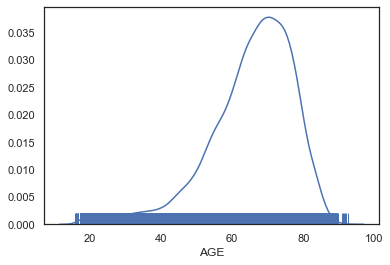

In [3]:
# check age looks OK
sns.distplot(dat['AGE'], hist=False, rug=True);

In [4]:
# drop < 18 yrs
dat = dat[dat.AGE >= 18]
dat['AGE'].describe()

count    28720.000000
mean        65.401136
std         12.107951
min         18.026010
25%         59.233402
50%         67.408624
75%         74.023536
max         92.563997
Name: AGE, dtype: float64

C:\Users\LyonMat\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\LyonMat\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


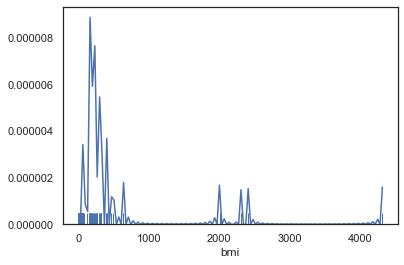

In [5]:
# check bmi looks OK
sns.distplot(dat['bmi'], hist=False, rug=True);

In [6]:
# set BMI outliers to NA
dat.loc[dat['bmi'] > 100, 'bmi'] = np.nan
dat.loc[dat['bmi'] < 5, 'bmi'] = np.nan

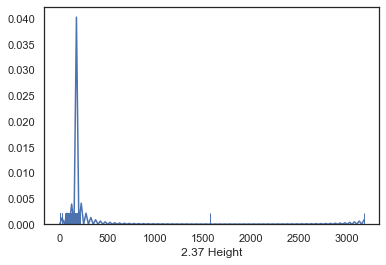

In [7]:
# check height looks OK
sns.distplot(dat['2.37 Height'], hist=False, rug=True);

In [8]:
# set height outliers to NA
dat.loc[dat['2.37 Height'] > 210, '2.37 Height'] = np.nan
dat.loc[dat['2.37 Height'] < 130, '2.37 Height'] = np.nan

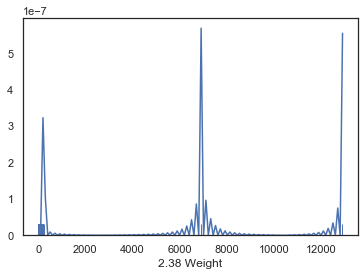

In [9]:
# check weight looks OK
sns.distplot(dat['2.38 Weight'], hist=False, rug=True);

In [10]:
# set weight outliers to NA
dat.loc[dat['2.38 Weight'] > 150, '2.38 Weight'] = np.nan
dat.loc[dat['2.38 Weight'] < 30, '2.38 Weight'] = np.nan

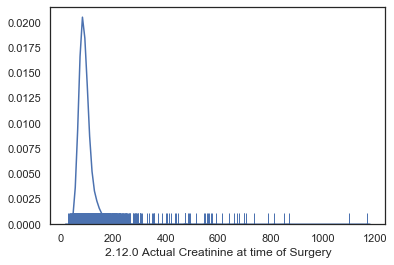

In [11]:
# check creatinine looks OK
sns.distplot(dat['2.12.0 Actual Creatinine at time of Surgery'], hist=False, rug=True);

In [12]:
# population charectoristics
dat.describe()

,AGE,2.12.0 Actual Creatinine at time of Surgery,2.23 PA Systolic,bmi,2.37 Height,2.38 Weight,YEAR,3.03 Responsible Consultant Surgeon,3.04 Responsible Consultant Anaesthetist,3.05 First Operator,...,3.41 Other Reason for Repeat Tricuspid Valve Replacement,3.62 Tricuspid valve or ring size,3.66 Pulmonary valve or ring size,Dissection,3.85 Cumulative Bypass time,3.87 Circulatory arrest time,LOS,TIME,Euroscore,Logistic_Euroscore
count,28720.000000,9056.000000,22015.000000,25410.000000,25483.000000,25370.000000,28720.000000,2.856200e+04,1.505100e+04,1.520100e+04,...,0.0,279.000000,294.000000,28720.000000,24541.000000,17702.000000,28720.000000,28720.000000,28720.000000,28720.000000
mean,65.401136,95.354130,8.447649,27.250297,171.223953,80.099204,2007.084436,3.340175e+06,1.152959e+06,1.466474e+06,...,NaN,31.437276,24.568027,0.013301,79.618944,1.106988,-11.293565,1942.275000,4.932974,0.061799
std,12.107951,45.514951,23.010755,5.008263,9.394687,15.838241,6.060854,1.050239e+06,1.519048e+06,1.917091e+06,...,NaN,2.780102,1.760526,0.114562,199.806582,7.314474,935.258196,1820.183709,3.042624,0.081716
min,18.026010,28.000000,0.000000,7.239711,132.000000,30.191000,1996.000000,9.000000e+00,1.000000e+00,5.000000e+00,...,NaN,23.000000,19.000000,0.000000,0.000000,0.000000,-43090.440972,0.000000,0.000000,0.008811
25%,59.233402,76.000000,0.000000,24.203206,165.000000,70.000000,2002.000000,2.542162e+06,8.000000e+00,1.500000e+01,...,NaN,30.000000,23.000000,0.000000,41.000000,0.000000,5.000000,214.000000,3.000000,0.019563
50%,67.408624,88.000000,0.000000,26.927438,172.000000,79.900000,2007.000000,3.339765e+06,2.800000e+01,2.230000e+02,...,NaN,32.000000,25.000000,0.000000,80.000000,0.000000,7.000000,1518.000000,5.000000,0.035731
75%,74.023536,103.250000,0.000000,30.071168,178.000000,89.000000,2012.000000,4.077976e+06,2.714619e+06,3.433690e+06,...,NaN,34.000000,25.000000,0.000000,109.000000,0.000000,10.000000,3260.000000,7.000000,0.069826
max,92.563997,1171.000000,299.000000,81.154841,206.000000,150.000000,2017.000000,7.438976e+06,6.069231e+06,7.028476e+06,...,NaN,36.000000,33.000000,1.000000,28112.000000,284.000000,445.000000,6329.000000,25.000000,0.969882


In [13]:
def split_dat_by_time(dat):
    # count rows
    obs = dat.shape[0]
    test_n = int(np.round(obs * 0.3, 0))
    train_n = obs - test_n

    # split data into train (70%) and test (30%)
    train = dat.head(train_n)
    test = dat.tail(test_n)
    
    assert (train.shape[0] + test.shape[0]) == obs
    
    return train, test

## Euroscore
Extract variables for Euroscore I and II and plot against provided calculations as sanity check

### EuroScore I
European Heart Journal (2003) 24, 1–2<br>
[10.1016/S0195-668X(02)00799-6](https://doi.org/10.1016/S0195-668X(02)00799-6)<br>
http://www.euroscore.org/euroscore_scoring.htm

In [14]:
def format_euroscore_i_features(dat):
    features = pd.DataFrame(data={
        'Age (continuous)' : dat['AGE'],
        'Female' : dat['SEX'] == "2. Female",
        'Serum creatinine >200 µmol/l': dat['CKD'] == "2. Creatinine > 200 µmol/l",
        "Extracardiac arteriopathy" : dat['PVD'] == "1. Yes",    
        "Pulmonary disease" : dat['PULMONARY'] == "1. COAD/Asthma/emphysema",
        "Neurological dysfunction": dat['NEURO_DYSF'] == "1. Yes",
        "Previous cardiac surgery" : dat['PRIOR_HEART_SURGERY'] == "1. Yes",
        'Recent myocardial infarct': dat['MI'].isin(["4. MI 31-90 days", "3. MI 1-30 days", "2. MI 6-24 hours", "1. MI < 6 hours"]),
        "LVEF 30–50%" : dat['LVEF'] == "2. Fair (LVEF 30-49%)",
        "LVEF <30%": dat['LVEF'] == "3. Poor (LVEF < 30%)",
        "Systolic pulmonary pressure >60 mmHg" : dat['PHPT60_EU1'] == "1. Yes",
        "Active endocarditis" : dat['ACTIVE_ENDOCARDITIS'] == "1. Yes",
        "Unstable angina" : dat['IVNITRATES'] == "1. Yes",
        "Emergency operation": dat['PRIORITY'].isin(['3. Emergency', '4. Salvage']),
        "Critical preoperative state": (dat['2.18 Pre operative heart rhythm'] == "3. Ventricular fibrillation or ventricular tachycardia") | (dat['SHOCK'] == "1. Yes") | (dat['INOTROPS'] == "1. Yes") | (dat['VENTILATION'] == "1. Yes") | (dat['IABP'] == "1. Yes"),
        "Ventricular septal rupture" : dat['Post infarct septal rupture'] == "1. Yes",
        "Other than isolated coronary surgery": (dat['VALVE'] == "1. Yes") | (dat['ASD'] == "1. Yes") | (dat['LV_ANEURYSMECTOMY'] == "1. Yes") | (dat['AF_ABLATION'] == "1. Yes") | (dat['PERICARDIECTOMY'] == "1. Yes")  | (dat['ATRIAL_MIXOMA'] == "1. Yes") | (dat['AORTIC_DISSECTION'] == "1. Yes"),    
        "Thoracic aortic surgery": dat['Surgery on thoracic aorta'] == "1. Yes",
    
        # outcome
        'STATUS_DISCHARGE': dat['STATUS_DISCHARGE'] == "1. Dead"
    }, index=dat.index)
    
    # drop samples with NAs
    features = features.dropna(axis='index')
    assert not features.isnull().values.any()
    
    return features

# select features and drop NA
esi_features = format_euroscore_i_features(dat)

# count remaining patients
print(esi_features.shape)

# split into test & train
train_pred_esi, test_pred_esi = split_dat_by_time(esi_features)

# print op date range for train & test
print(dat.loc[train_pred_esi.head(1).index.tolist()[0]]['Date of operation fixed'])
print(dat.loc[train_pred_esi.tail(1).index.tolist()[0]]['Date of operation fixed'])
print(dat.loc[test_pred_esi.head(1).index.tolist()[0]]['Date of operation fixed'])
print(dat.loc[test_pred_esi.tail(1).index.tolist()[0]]['Date of operation fixed'])

# write out to csv
train_pred_esi.to_csv('train.esi.features.17.02.20.csv')
test_pred_esi.to_csv('test.esi.features.17.02.20.csv')

# write out provided ES calc for comparison
dat.to_csv('Euroscore_additive.17.02.20.csv', columns=['Euroscore'])
dat.to_csv('Euroscore_logistic.17.02.20.csv', columns=['Logistic_Euroscore'])

(28720, 19)
1996-04-01 00:00:00
2011-09-27 00:00:00
2011-09-27 00:00:00
2017-12-30 13:30:00


# EuroScore II
European Journal of Cardio-Thoracic Surgery 41 (2012) 734–745<br>
[10.1093/ejcts/ezs043](https://doi.org/10.1093/ejcts/ezs043)<br>
http://euroscore.org/calc.html

In [15]:
def count_procedures(dat):
    procedure_counts = []
    
    for index, row in dat.iterrows():
        count = 0
        
        # note the space after key CABG
        if row['CABG '] == '1. Yes':
            count += 1
        if row['VALVE'] == '1. Yes':
            count += 1
        if row['Surgery on thoracic aorta'] == '1. Yes':
            count += 1
        if row['Post infarct septal rupture'] == '1. Yes':
            count += 1
        if ['ASD'] == '1. Yes':
            count += 1
        if row['LV_ANEURYSMECTOMY'] == '1. Yes':
            count += 1
        if row['AF_ABLATION'] == '1. Yes':
            count += 1
        if row['PERICARDIECTOMY'] == '1.Yes':
            count += 1
        if row['ATRIAL_MIXOMA'] == '1. Yes':
            count += 1
        
        procedure_counts.append(count)
    
    assert len(procedure_counts) == dat.shape[0]
    
    return pd.DataFrame(data={'number of procedures': procedure_counts}, index=dat.index)

In [16]:
# requires creatinine in umol/L
def calc_cockcroft_gault(row):
    try:
        if row['SEX'] == "2. Female":
            n = (140 - row['AGE']) * row['2.38 Weight'] * 0.85
        else:
            n = (140 - row['AGE']) * row['2.38 Weight']
    
        # convert umol/L to mg/dL
        mg_dl = row['2.12.0 Actual Creatinine at time of Surgery'] * 0.0113
        return n / (72 * mg_dl)
    except (TypeError, KeyError):
        return None
    
# check func against http://touchcalc.com/calculators/cg
assert calc_cockcroft_gault({'SEX': '1. Male', 'AGE': 65, '2.38 Weight': 78, '2.12.0 Actual Creatinine at time of Surgery': 100}) == approx(71.83, rel=0.01)
assert calc_cockcroft_gault({'SEX': '2. Female', 'AGE': 65, '2.38 Weight': 78, '2.12.0 Actual Creatinine at time of Surgery': 100}) == approx(61.05, rel=0.01)
assert calc_cockcroft_gault({'SEX': '1. Male', 'AGE': 65, '2.38 Weight': 78, '2.12.0 Actual Creatinine at time of Surgery': 200}) == approx(35.91, rel=0.01)
assert calc_cockcroft_gault({'SEX': '1. Male', 'AGE': 65, '2.38 Weight': 120, '2.12.0 Actual Creatinine at time of Surgery': 100}) == approx(110.05, rel=0.01)
assert calc_cockcroft_gault({'SEX': '1. Male', 'AGE': 80, '2.38 Weight': 78, '2.12.0 Actual Creatinine at time of Surgery': 100}) == approx(57.46, rel=0.01)
assert calc_cockcroft_gault({'SEX': '1. Male', 'AGE': 65, '2.38 Weight': 78, '2.12.0 Actual Creatinine at time of Surgery': None}) is None 
assert calc_cockcroft_gault({'SEX': '1. Male', 'AGE': None, '2.38 Weight': 78, '2.12.0 Actual Creatinine at time of Surgery': 100}) is None

def get_creatinine_clearance(dat):
    creatinine_clearance = []
    for index, row in dat.iterrows():
        creatinine_clearance.append(calc_cockcroft_gault(row))
    assert len(creatinine_clearance) == dat.shape[0]
    return pd.DataFrame(data={'CC' : creatinine_clearance}, index=dat.index)

In [17]:
def format_euroscore_ii_features(dat):
    cc = get_creatinine_clearance(dat)
    no = count_procedures(dat)

    features = pd.DataFrame(data={
        # New York Heart Association classification of heart failure
        'NYHA - II' : dat['NYHA'] == "2. Slight limitation of ordinary physical activity",
        'NYHA - III' : dat['NYHA'] == "3. Marked limitation of ordinary physical activity",
        'NYHA - IV' : dat['NYHA'] == "4. Symptoms at rest or minimal activity",
    
        # Canadian Cardiovascular Society classification of angina
        'CCS4' : dat['ANGINA'] == "4. Symptoms at rest or minimal activity",
    
        # Insulin-dependent diabetes mellitus
        'IDDM' : dat['DIABETES'] == "3. Insulin",
    
        'Age' : dat['AGE'],
        'Female' : dat['SEX'] == "2. Female",
    
        # Extracardiac arteriopathy
        "ECA" : dat['PVD'] == "1. Yes",
    
        # Chronic pulmonary dysfunction
        "CPD" : dat['PULMONARY'] == "1. COAD/Asthma/emphysema",
    
        # Neurological or musculoskeletal dysfunction severely affecting mobility
        "N/M mob": dat['NEURO_DYSF'] == "1. Yes",
    
        # Previous cardiac surgery
        "Redo" : dat['PRIOR_HEART_SURGERY'] == "1. Yes",
    
        # Creatinine clearance
        'Renal dysfunction - On dialysis' : dat['CKD'] == "4. Chronic Dialysis",
        'Renal dysfunction - CC <= 50' : cc['CC'] <= 50,
        'Renal dysfunction - CC 50−85' : (cc['CC'] > 50) & (cc['CC'] <= 85),
    
        # Active endocarditis
        "AE" : dat['ACTIVE_ENDOCARDITIS'] == "1. Yes",
    
        # Critical preoperative state
        "Critical": (dat['2.18 Pre operative heart rhythm'] == "3. Ventricular fibrillation or ventricular tachycardia") | (dat['SHOCK'] == "1. Yes") | (dat['INOTROPS'] == "1. Yes") | (dat['VENTILATION'] == "1. Yes") | (dat['IABP'] == "1. Yes"),
    
        # Left ventricle function
        "LV function - Moderate" : dat['LVEF'] == "2. Fair (LVEF 30-49%)",
        "LV function - Poor" : dat['LVEF'] == "3. Poor (LVEF < 30%)",
    
        # Recent myocardial infarct
        'Recent MI': dat['MI'].isin(["4. MI 31-90 days", "3. MI 1-30 days", "2. MI 6-24 hours", "1. MI < 6 hours"]),
    
        # Pulmonary artery systolic pressure
        'PA systolic pressure - 31–55 mmHg': dat['Pulmo_hy_Eu2'] == '31-55',
        'PA systolic pressure - >=55 mmHg': dat['Pulmo_hy_Eu2'] == '>55',
    
        # Urgency
        "Urgency - Urgent": dat['PRIORITY'] == '2. Urgent',
        "Urgency - Emergency": dat['PRIORITY'] == '3. Emergency',
        "Urgency - Salvage": dat['PRIORITY'] == '4. Salvage',
    
        # Weight of procedure
        # note the space after key CABG
        'Weight of procedure - 1 non-CABG' : (no['number of procedures'] == 1) & (dat['CABG '] == "0. No"),
        'Weight of procedure - 2' : no['number of procedures'] == 2,
        'Weight of procedure - 3+' : no['number of procedures'] >= 3,
    
        # surgery of thoracic aorta
        "Thoracic aorta": dat['Surgery on thoracic aorta'] == "1. Yes",
    
        # outcome
        'STATUS_DISCHARGE': dat['STATUS_DISCHARGE'] == "1. Dead"
    }, index=dat.index)
    
    # set cc=NA correctly
    features['Renal dysfunction - CC <= 50'] = features['Renal dysfunction - CC <= 50'].where(cc['CC'].notnull(), np.nan)
    features['Renal dysfunction - CC 50−85'] = features['Renal dysfunction - CC 50−85'].where(cc['CC'].notnull(), np.nan)
        
    # drop samples with NAs
    features = features.dropna(axis='index')
    assert not features.isnull().values.any()
    
    return features

# select features and drop NA
esii_features = format_euroscore_ii_features(dat)

# count remaining patients
print(esii_features.shape)

# split into test & train
train_pred_esii, test_pred_esii = split_dat_by_time(esii_features)

# write out to csv
train_pred_esii.to_csv('train.esii.features.17.02.20.csv')
test_pred_esii.to_csv('test.esii.features.17.02.20.csv')

(6298, 29)


## Hypothesis-free feature selection
start with the features selected by Umberto

In [18]:
def format_features(df, keep_cols_with_frac_populated=0.8, fields_to_drop=None):
    
    # select predictors
    features = df[[
        'AGE',
        'SEX',
        'ANGINA',
        'NYHA',
        'MI',
        'PCI',
        'DIABETES',
        'SMOKING',
        'CKD',
        'PULMONARY',
        'STROKE',
        'NEURO_DYSF',
        'PVD',
        'AF',
        'Pulmo_hy_Eu2',
        'PHPT60_EU1',
        'LVEF',
        'IVNITRATES',
        'SHOCK',
        'INOTROPS',
        'VENTILATION',
        'IABP',
        'PRIORITY',
        'PRIOR_HEART_SURGERY',
        'BMI_cat',
        'bmi',
        '2.37 Height',
        '2.38 Weight',
        'YEAR',
        '3.06 First Operator Grade',
        'CABG ',
        'VALVE',
        'Surgery on thoracic aorta',
        'Post infarct septal rupture',
        'ASD',
        'LV_ANEURYSMECTOMY',
        'AF_ABLATION',
        'PERICARDIECTOMY',
        'ATRIAL_MIXOMA',
        'AORTIC_DISSECTION',
        'ACTIVE_ENDOCARDITIS',
        'AV',
        'MV',
        'TV',
        'PV',
        'FRR',
        'type FRR',
        '2.12.0 Actual Creatinine at time of Surgery',
        'STATUS_DISCHARGE'
    ]]
    
    # drop cols with high missing rate
    features = features.dropna(axis='columns', thresh=(features.shape[0] * keep_cols_with_frac_populated))
    
    # drop samples with NAs
    features = features.dropna(axis='index')
        
    # select predictors
    predictors = features.drop(columns=['STATUS_DISCHARGE'])
    
    # select outcome
    outcome = features[['STATUS_DISCHARGE']]
    
    # identify categorical fields
    cat_columns = predictors.select_dtypes(['object']).columns
    
    # convert categorical variables to factors
    predictors[cat_columns] = predictors[cat_columns].astype('category')
    outcome = outcome.astype('category')
    
    # convert factor to int
    predictors[cat_columns] = predictors[cat_columns].apply(lambda x: x.cat.codes)
    outcome = outcome.apply(lambda x: x.cat.codes)
    
    assert not predictors.isnull().values.any()
    assert not outcome.isnull().values.any()
    
    # drop features if required
    if fields_to_drop is None:
        return predictors, outcome
    else:
        return predictors.drop(fields_to_drop, axis=1), outcome

In [19]:
train, test = split_dat_by_time(dat)

# format data
train_pred, train_out = format_features(train)
test_pred, test_out = format_features(train)

## Feature correlation
Evaluate colinearity between variables which make the model complex but add nothing and may lead to overfitting

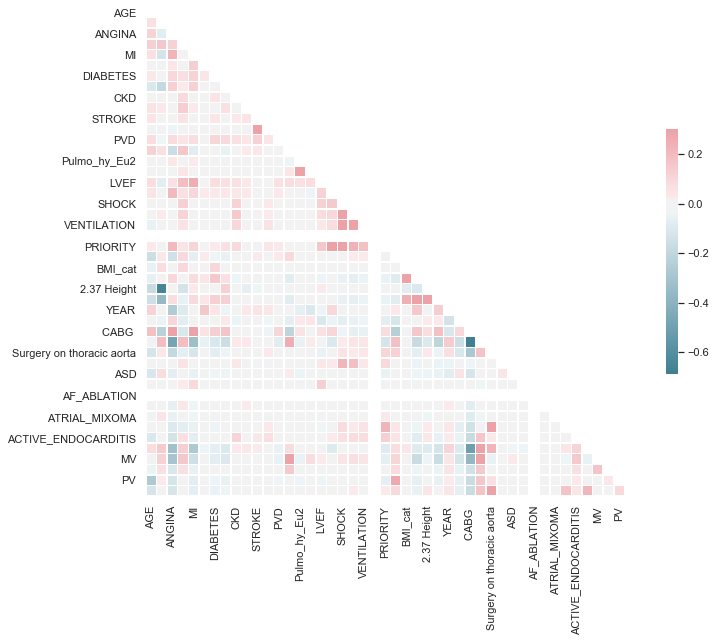

In [20]:
# Compute the correlation matrix
corr = train_pred.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
# print correlated pairs
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(train_pred, 50))

bmi                        2.38 Weight                    0.828196
Pulmo_hy_Eu2               PHPT60_EU1                     0.801640
VALVE                      AV                             0.788179
CABG                       VALVE                          0.687628
SEX                        2.37 Height                    0.655761
SHOCK                      INOTROPS                       0.644499
Surgery on thoracic aorta  FRR                            0.609502
INOTROPS                   VENTILATION                    0.562174
ANGINA                     CABG                           0.539131
Surgery on thoracic aorta  AORTIC_DISSECTION              0.523769
CABG                       AV                             0.508859
VALVE                      MV                             0.486161
ANGINA                     VALVE                          0.477451
2.37 Height                2.38 Weight                    0.467240
SHOCK                      VENTILATION                    0.45

## Feature importance
Select is driven by Random forest feature importance metric

In [22]:
def get_feature_importance(pred, out):
    
    # fit RF with all variables using five-fold CV
    clf = RandomForestClassifier(random_state=0, n_estimators=100)
    scores = cross_val_score(clf, pred, out.values.ravel(), cv=5, scoring='roc_auc')
    
    # get feature importance measures
    clf.fit(pred, out.values.ravel())
    fi = pd.DataFrame(data={'predictor' : pred.columns, 'feature_importance': clf.feature_importances_})
    
    return fi

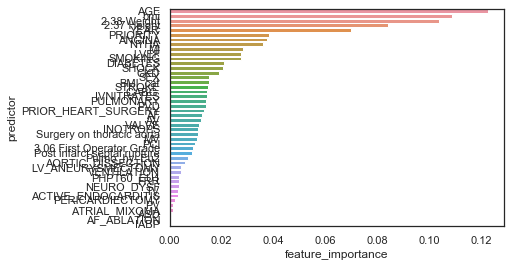

In [23]:
# plot feature importance measures
fi = get_feature_importance(train_pred, train_out)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False))

#### Recursive feature elimination with cross-validation
Starting with all variables drop one-at-a-time starting with least importance and evaluate ROC AUC

Optimal number of features : 44


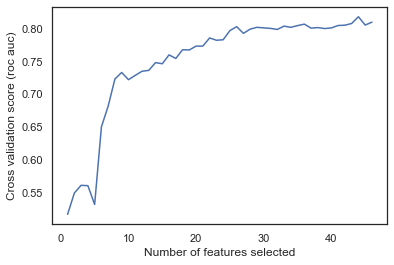

In [24]:
# using random forest classifier with feature importance measure perform feature elimination
clf = RandomForestClassifier(random_state=0, n_estimators=100)
rfecv = RFECV(estimator=clf, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(train_pred, train_out.values.ravel())

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
# Do the variables add something to the model? True=Yes
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [26]:
# Get the roc auc scores for each model
rfecv.grid_scores_

array([0.51617075, 0.54883408, 0.56056402, 0.56004553, 0.53138378,
       0.64968914, 0.6815541 , 0.72295457, 0.73287354, 0.72180335,
       0.72841809, 0.73467526, 0.73605208, 0.74792174, 0.74614268,
       0.75971538, 0.75422278, 0.76750796, 0.76727554, 0.77307188,
       0.7731124 , 0.78557607, 0.7820156 , 0.78276138, 0.7967796 ,
       0.80277102, 0.79253577, 0.79906717, 0.80177054, 0.80089897,
       0.80013157, 0.79852106, 0.80360592, 0.80175563, 0.8043605 ,
       0.80663429, 0.80051994, 0.80137445, 0.7999099 , 0.80083292,
       0.80454857, 0.80499539, 0.80761965, 0.81791125, 0.80520415,
       0.80968565])

#### Drop specific variables to see if we can do without
Feature elimination suggested to keep all variables so instead try eliminating manually

In [27]:
def get_roc_for_rf(pred, out):
    clf = RandomForestClassifier(random_state=0, n_estimators=100)
    scores = cross_val_score(clf, pred, out.values.ravel(), cv=5, scoring='roc_auc')
    return "cross validation (k=5) roc auc: mean {}, std {}, variables {}".format(np.round(np.mean(scores), 3), np.round(np.std(scores), 3), len(pred.columns))

In [28]:
# All 47 variables
get_roc_for_rf(train_pred, train_out)

'cross validation (k=5) roc auc: mean 0.81, std 0.023, variables 46'

In [29]:
# use feature importance to drop the last 22 variables that do not add much to the model
# drop highly correlated variables selecting the best feature importance measure
fields_to_drop = list(fi.sort_values(by=['feature_importance'], ascending=True)[0:21]['predictor'])
fields_to_drop.append('PHPT60_EU1')
fields_to_drop.append('bmi')
fields_to_drop.append('YEAR') # not useful for future prediction
fields_to_drop.append('BMI_cat')
print(fields_to_drop)

['AF_ABLATION', 'IABP', 'ASD', 'ATRIAL_MIXOMA', 'PV', 'PERICARDIECTOMY', 'ACTIVE_ENDOCARDITIS', 'TV', 'NEURO_DYSF', 'FRR', 'PHPT60_EU1', 'VENTILATION', 'LV_ANEURYSMECTOMY', 'AORTIC_DISSECTION', 'Pulmo_hy_Eu2', 'Post infarct septal rupture', '3.06 First Operator Grade', 'PCI', 'MV', 'Surgery on thoracic aorta', 'INOTROPS', 'PHPT60_EU1', 'bmi', 'YEAR', 'BMI_cat']


In [30]:
train_pred_subset, train_out_subset = format_features(train, fields_to_drop=fields_to_drop)
get_roc_for_rf(train_pred_subset, train_out_subset)

'cross validation (k=5) roc auc: mean 0.798, std 0.028, variables 22'

In [31]:
train_pred_subset.columns

Index(['AGE', 'SEX', 'ANGINA', 'NYHA', 'MI', 'DIABETES', 'SMOKING', 'CKD',
       'PULMONARY', 'STROKE', 'PVD', 'AF', 'LVEF', 'IVNITRATES', 'SHOCK',
       'PRIORITY', 'PRIOR_HEART_SURGERY', '2.37 Height', '2.38 Weight',
       'CABG ', 'VALVE', 'AV'],
      dtype='object')

### select final predictors

In [32]:
def format_final_features(df):
    
    final_predictors = ['AGE', 'SEX', 'ANGINA', 'NYHA', 'MI', 'DIABETES', 'SMOKING',
       'PULMONARY', 'STROKE', 'PVD', 'AF', 'LVEF', 'IVNITRATES', 'SHOCK', 'CKD',
       'INOTROPS', 'PRIORITY', 'PRIOR_HEART_SURGERY', '2.37 Height',
       '2.38 Weight', 'CABG ', 'Surgery on thoracic aorta', 'AV']

    final_predictors.append('STATUS_DISCHARGE')
    
    # select predictors
    features = df[final_predictors]
        
    # drop samples with NAs
    features = features.dropna(axis='index')
        
    # select predictors
    predictors = features.drop(columns=['STATUS_DISCHARGE'])
    
    # select outcome
    outcome = features[['STATUS_DISCHARGE']]
    
    # identify categorical fields
    cat_columns = predictors.select_dtypes(['object']).columns
    
    # convert categorical variables to factors
    predictors[cat_columns] = predictors[cat_columns].astype('category')
    outcome = outcome.astype('category')
    
    # convert factor to int
    predictors[cat_columns] = predictors[cat_columns].apply(lambda x: x.cat.codes)
    outcome = outcome.apply(lambda x: x.cat.codes)
    
    assert not predictors.isnull().values.any()
    assert not outcome.isnull().values.any()
    
    return predictors, outcome

In [33]:
# get final predictors and run the roc curve
train_pred_final, train_out_final = format_final_features(train)
get_roc_for_rf(train_pred_final, train_out_final)

'cross validation (k=5) roc auc: mean 0.801, std 0.035, variables 23'

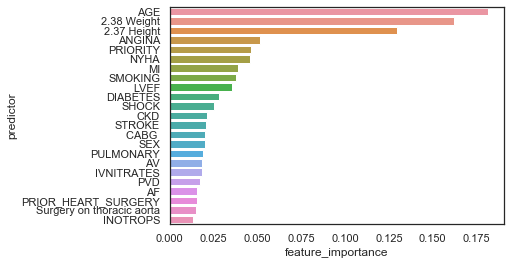

In [34]:
# plot feature importance measures
fi = get_feature_importance(train_pred_final, train_out_final)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False))

In [35]:
# save data to csv for model development

train_pred_final, train_out_final = format_final_features(train)
pd.concat([train_pred_final, train_out_final], axis=1).to_csv('train.selected.features.17.02.20.csv')

test_pred_final, test_out_final = format_final_features(test)
pd.concat([test_pred_final, test_out_final], axis=1).to_csv('test.selected.features.17.02.20.csv')

In [36]:
test_pred_final.describe()

,AGE,SEX,ANGINA,NYHA,MI,DIABETES,SMOKING,PULMONARY,STROKE,PVD,...,SHOCK,CKD,INOTROPS,PRIORITY,PRIOR_HEART_SURGERY,2.37 Height,2.38 Weight,CABG,Surgery on thoracic aorta,AV
count,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,...,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000,6484.000000
mean,65.868692,0.267890,1.426434,1.224399,1.032542,0.409932,0.661320,0.143893,0.124923,0.093615,...,0.011413,0.026064,0.006015,0.475170,0.067551,171.542258,82.431462,0.572949,0.075725,0.334207
std,13.159762,0.442894,1.347635,0.799169,1.722904,0.893565,0.665384,0.351008,0.483064,0.291315,...,0.106227,0.235187,0.077328,0.593684,0.250993,9.577287,16.629659,0.494688,0.264578,0.471749
min,18.026010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,132.000000,33.000000,0.000000,0.000000,0.000000
25%,59.397388,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,165.000000,71.000000,0.000000,0.000000,0.000000
50%,68.616530,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,172.000000,81.000000,1.000000,0.000000,0.000000
75%,75.151528,1.000000,2.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,178.000000,93.000000,1.000000,0.000000,1.000000
max,89.350876,1.000000,4.000000,3.000000,5.000000,3.000000,2.000000,1.000000,3.000000,1.000000,...,1.000000,3.000000,1.000000,3.000000,1.000000,202.000000,149.000000,1.000000,1.000000,1.000000
